# 3b. Bag of Words Word Vectorizing Methods (II): Count TFIDF Vectorizer (Term Frequency-Inverse Document Frequency) 

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for "Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This downscales words that appear a lot across documents.

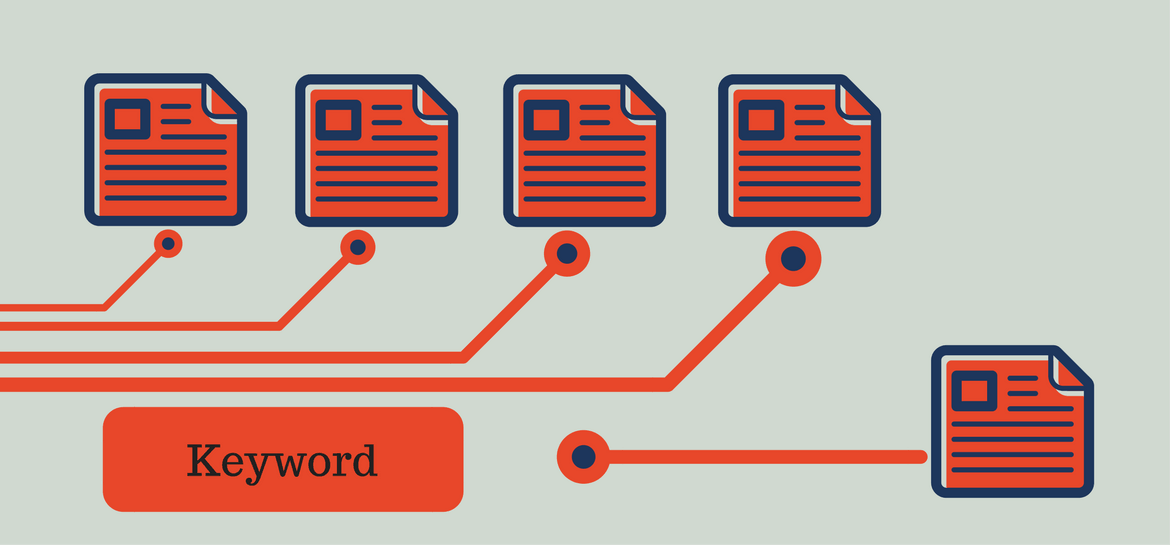

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow to encode new documents. Alternately, if we already have a learned CountVectorizer, we can use it with a TfidfTransformer to just calculate the inverse document frequencies and start encoding documents.

The same create, fit, and transform process is used as with the CountVectorizer.

In [77]:
# import necessary libraries

import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from  sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [78]:
# read the data into a DataFrame
df = pd.read_csv('2_explored.csv', index_col=0)

Here, I will vectorize the text and transform it to a matrix form so that I can feed the matrix to machine learning algorithms. Xs are the words and y is the rating stored in 'overall' column.

In [79]:
vect = TfidfVectorizer(ngram_range=(1,1))
                       
vect.fit(df.clean_text)
X = vect.transform(df.clean_text)

# transform the resulting sparse matrix into an array
my_array = X.toarray()

# check the vocabulary length
vocab = vect.get_feature_names()
print('Number of words in the vocabulary: ', len(vocab))

# back to df, assign column names
X_df = pd.DataFrame(my_array, columns = vocab)

# check the vector matrix
X_df.head()

Number of words in the vocabulary:  4264


,abartlan,abi,abicim,abilerim,abimiz,abimizin,ac,acaip,acar,acayip,...,zor,zordu,zorla,zorlandk,zorlu,zorluk,zorunda,zorundalar,zorundaydm,zorunlu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# assign the target variable 'overall' to y
y = df.rating

We will train the data on one set and test on a set not seen before to reduce bias.

In [81]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123,
                                                    stratify = y)

I will define a function to better visualize the test results given by the confusion matrix.

In [82]:
# Function for plotting a good-looking confusion matrix

def plot_confusion_matrix(y_test, y_pred, title, color):
    
    '''This function takes as input: 
            a target test variable y_test (pandas series of type integer), 
            a target predicted variable y_pred (pandas series of type integer), 
            a colormap color (string) and 
            a title (string). 
        It plots a confusion matrix of y_test and y_pred with the input colormap.
    '''
    
    cm_ratio = np.round(confusion_matrix(y_test, y_pred) / len(y_test), decimals=2)
    fig = plt.figure(figsize=(4, 4))
    plt.clf()
    plt.style.use('classic')
    plt.imshow(cm_ratio, interpolation='nearest', cmap=color)
    classNames = ['Neg_Review',' Pos_Review']
    plt.title(title, fontsize=20)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, fontsize=15)
    plt.yticks(tick_marks, classNames, fontsize=15, rotation=90)
    s = [['TNR','FPR'], ['FNR', 'TPR']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm_ratio[i][j]), fontsize=15, 
                 fontweight='bold', horizontalalignment="center")
    return plt.show()

I will code a function to facilitate fitting a classifier to training data, predicting on test data, printing the accuracy and cross validation scores along with the classification report and showing the confusion matrix results using the function above.

In [83]:
def fit_predict_print_plot(my_classifier, my_title):
    
    '''This function takes an instance of a classifier and my_title string, fits to training data, 
    predicts on test data, prints and plots the results'''
    
    # Fitting the classifier to the training data split    
    my_classifier.fit(X_train, y_train)

    # Predicting on the test split
    y_predicted = my_classifier.predict(X_test)

    # Checking the accuracy and the cross validation scores
    print('accuracy on training set: ', my_classifier.score(X_train, y_train))
    print('accuracy on test set: ', accuracy_score(y_test, y_predicted))
    print('croos validation score on whole data set: ', 
          np.mean(cross_val_score(my_classifier, X, y, cv = 5)), '\n')

    # Checking the results with the Classification report
    print (classification_report(y_test, y_predicted))
    
    # Checking the results visually by Plotting the confusion matrix with "plot_confusion_matrix" function I defined above
    plot_confusion_matrix(y_test, y_predicted, 
                      title = my_title, 
                      color=plt.cm.Set3)
    return(y_predicted)

Starting with logistic regression, I will use different classification algorithms to predict the ratings of the reviews. Namely: Logistic Regression, K-Nearest Neighbors, Linear Support Vector Machines (SVM), Kernel SVM, Naive Bayes, Decision Trees, Random Forest, AdaBoost, Gradient Boosting, Stochastic Gradient Boosting, Extreme Gradient Boosting (XGBoost) and CatBoost.

## 3.1. Logistic Regression

accuracy on training set:  0.831764705882353
accuracy on test set:  0.7934272300469484
croos validation score on whole data set:  0.7958543715120914 

              precision    recall  f1-score   support

           0       1.00      0.08      0.15        48
           1       0.79      1.00      0.88       165

    accuracy                           0.79       213
   macro avg       0.89      0.54      0.52       213
weighted avg       0.84      0.79      0.72       213



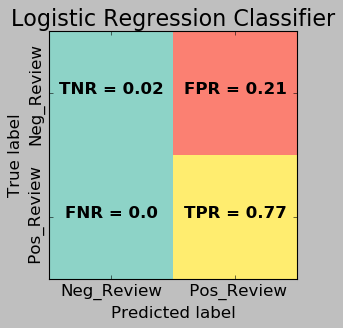

In [84]:
# Instantiating the logistic regression classifier logreg
logreg = LogisticRegression(penalty = 'l2', C = 1, solver='newton-cg', random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_logreg = fit_predict_print_plot(logreg, 'Logistic Regression Classifier')

## 3.2. K-Neighbors Classifier

accuracy on training set:  0.8623529411764705
accuracy on test set:  0.8450704225352113
croos validation score on whole data set:  0.8372353618566747 

              precision    recall  f1-score   support

           0       0.83      0.40      0.54        48
           1       0.85      0.98      0.91       165

    accuracy                           0.85       213
   macro avg       0.84      0.69      0.72       213
weighted avg       0.84      0.85      0.82       213



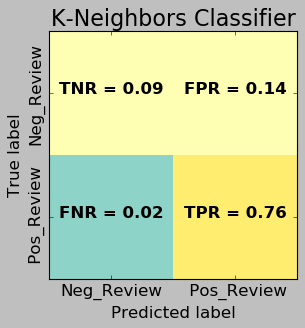

In [85]:
# Instantiating the KNeighborsClassifier knn
knn = KNeighborsClassifier(n_neighbors=5)

# Calling the fit_predict_print_plot function I defined above
y_predicted_knn = fit_predict_print_plot(knn, 'K-Neighbors Classifier')

## 3.3. Linear SVM

accuracy on training set:  0.9882352941176471
accuracy on test set:  0.8544600938967136
croos validation score on whole data set:  0.8523252723890513 

              precision    recall  f1-score   support

           0       0.95      0.38      0.54        48
           1       0.85      0.99      0.91       165

    accuracy                           0.85       213
   macro avg       0.90      0.68      0.73       213
weighted avg       0.87      0.85      0.83       213



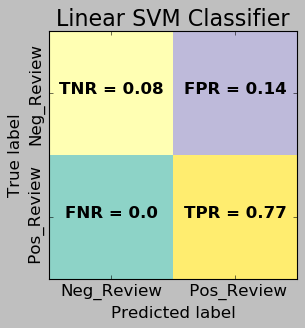

In [86]:
# Instantiating the KNeighborsClassifier knn
l_svm = SVC(kernel='linear', random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_l_svm = fit_predict_print_plot(l_svm, 'Linear SVM Classifier')

## 3.4. Kernel SVM

accuracy on training set:  0.7764705882352941
accuracy on test set:  0.7746478873239436
croos validation score on whole data set:  0.7761094871113473 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.77      1.00      0.87       165

    accuracy                           0.77       213
   macro avg       0.39      0.50      0.44       213
weighted avg       0.60      0.77      0.68       213



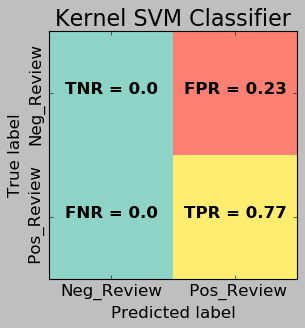

In [87]:
# Instantiating the KNeighborsClassifier knn
k_svm = SVC(kernel='rbf', gamma='auto')

# Calling the fit_predict_print_plot function I defined above
y_predicted_k_svm = fit_predict_print_plot(k_svm, 'Kernel SVM Classifier')

## 3.5. Naive Bayes

accuracy on training set:  0.851764705882353
accuracy on test set:  0.784037558685446
croos validation score on whole data set:  0.7836433696518734 

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        48
           1       0.78      1.00      0.88       165

    accuracy                           0.78       213
   macro avg       0.89      0.52      0.48       213
weighted avg       0.83      0.78      0.70       213



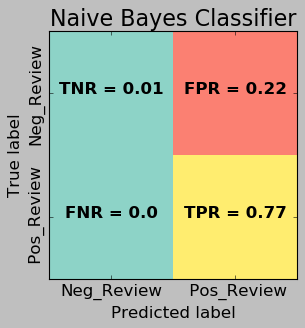

In [88]:
# Instantiating the Naive Bayes Classifier nb
nb = MultinomialNB()

# Calling the fit_predict_print_plot function I defined above
y_predicted_nb = fit_predict_print_plot(nb, 'Naive Bayes Classifier')

## 3.6. Decision Tree Classifier

accuracy on training set:  0.7764705882352941
accuracy on test set:  0.7746478873239436
croos validation score on whole data set:  0.7761094871113473 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.77      1.00      0.87       165

    accuracy                           0.77       213
   macro avg       0.39      0.50      0.44       213
weighted avg       0.60      0.77      0.68       213



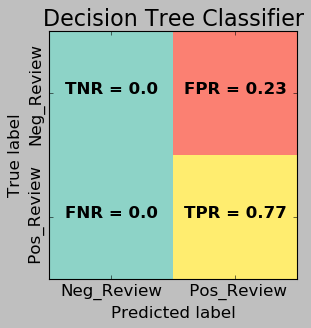

In [89]:
# Instantiating the Decision Tree Classifier dt
dt = DecisionTreeClassifier(max_depth = 6, max_features = 0.6, 
                             min_samples_leaf = 0.08, random_state = 123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_dt = fit_predict_print_plot(dt, 'Decision Tree Classifier')

## 3.7. Random Forest 

accuracy on training set:  0.9988235294117647
accuracy on test set:  0.8169014084507042
croos validation score on whole data set:  0.8306847373549473 

              precision    recall  f1-score   support

           0       1.00      0.19      0.32        48
           1       0.81      1.00      0.89       165

    accuracy                           0.82       213
   macro avg       0.90      0.59      0.61       213
weighted avg       0.85      0.82      0.76       213



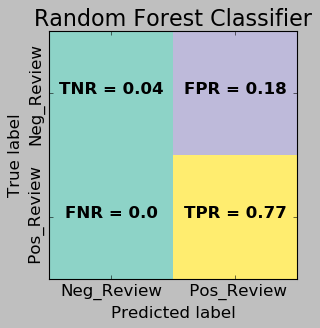

In [90]:
# Instantiating the Random Forest Classifier rf
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_rf = fit_predict_print_plot(rf, 'Random Forest Classifier')

## 3.8. AdaBoosting

accuracy on training set:  0.78
accuracy on test set:  0.7699530516431925
croos validation score on whole data set:  0.7723536185667463 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.77      0.99      0.87       165

    accuracy                           0.77       213
   macro avg       0.39      0.50      0.44       213
weighted avg       0.60      0.77      0.67       213



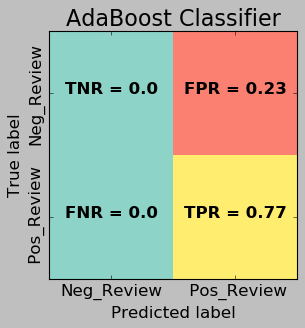

In [91]:
# Instantiating the AdaBoost Classifier adb
adb = AdaBoostClassifier(base_estimator = dt, n_estimators = 100)

# Calling the fit_predict_print_plot function I defined above
y_predicted_adb = fit_predict_print_plot(adb, 'AdaBoost Classifier')

## 3.9. GradientBoosting

accuracy on training set:  0.9988235294117647
accuracy on test set:  0.8262910798122066
croos validation score on whole data set:  0.8466781823013554 

              precision    recall  f1-score   support

           0       0.79      0.31      0.45        48
           1       0.83      0.98      0.90       165

    accuracy                           0.83       213
   macro avg       0.81      0.64      0.67       213
weighted avg       0.82      0.83      0.80       213



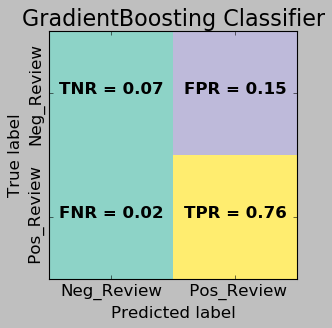

In [92]:
# Instantiating the GradientBoosting Classifier gbt
gbt = GradientBoostingClassifier(n_estimators=300, max_depth =3, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_gbt = fit_predict_print_plot(gbt, 'GradientBoosting Classifier')

## 3.10. Stochastic Gradient Boosting

accuracy on training set:  0.9988235294117647
accuracy on test set:  0.8215962441314554
croos validation score on whole data set:  0.853250952254407 

              precision    recall  f1-score   support

           0       0.71      0.35      0.47        48
           1       0.84      0.96      0.89       165

    accuracy                           0.82       213
   macro avg       0.77      0.66      0.68       213
weighted avg       0.81      0.82      0.80       213



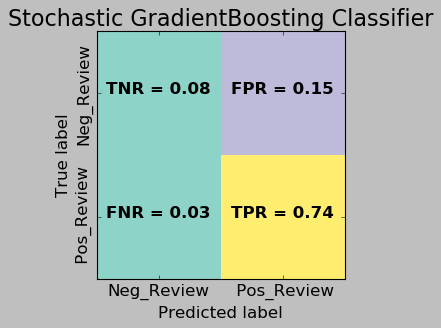

In [93]:
# Instantiating the Stochastic GradientBoosting Classifier sgbt
sgb = GradientBoostingClassifier(max_depth=3, subsample=0.8, 
                                   max_features=0.2, n_estimators=300, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_sgb = fit_predict_print_plot(sgb, 'Stochastic GradientBoosting Classifier')

## 3.11. XGBoost

accuracy on training set:  0.8823529411764706
accuracy on test set:  0.8028169014084507
croos validation score on whole data set:  0.8334883514926036 

              precision    recall  f1-score   support

           0       0.69      0.23      0.34        48
           1       0.81      0.97      0.88       165

    accuracy                           0.80       213
   macro avg       0.75      0.60      0.61       213
weighted avg       0.78      0.80      0.76       213



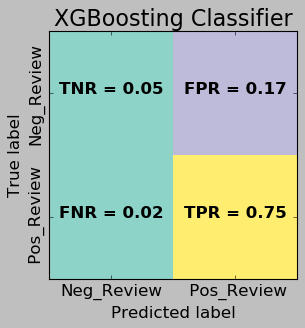

In [94]:
# Instantiating the XGBoosting Classifier xgb
xgb = XGBClassifier(random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_xgb = fit_predict_print_plot(xgb, 'XGBoosting Classifier')

## 3.12. CatBoost

accuracy on training set:  0.9329411764705883
accuracy on test set:  0.8262910798122066
croos validation score on whole data set:  0.8438435645318452 

              precision    recall  f1-score   support

           0       0.82      0.29      0.43        48
           1       0.83      0.98      0.90       165

    accuracy                           0.83       213
   macro avg       0.83      0.64      0.66       213
weighted avg       0.83      0.83      0.79       213



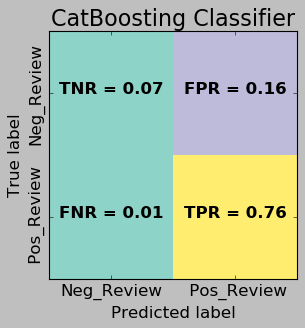

In [95]:
# Instantiating the Cat Boosting Classifier cb
cb = CatBoostClassifier(verbose=False, random_state=123)

# Calling the fit_predict_print_plot function I defined above
y_predicted_cb = fit_predict_print_plot(cb, 'CatBoosting Classifier')

## Comparison of results

I will use two functions to build a DataFrame for comparison.

In [96]:
# Function for converting the classification report results to a dataframe

def get_classification_report(y_true, y_pred):
    
    '''This function takes in true (y_true) and predicted (y_pred) values of a target variable and produces 
    a classification report '''
    
    metrics_summary = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)

    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary), index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

In [97]:
# Function for adding explanatory columns and organizing the dataframe

def build_comparison_matrix(y_test, y_pred, algorithm, vector):
    
    '''This function builds a comparison matrix as a DataFrame, given target variable test and prediction values
    as pandas Series of integers, name of the algorithm of type string and name of the word vectorizer as string'''
    
    df = get_classification_report(y_test, y_pred)
    df['class']=['neg_review', 'pos_review', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = algorithm
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    
    return df

In [98]:
#For loop using above functions to build CountVectorizing results table

frames = [] # empty list for collecting dataframes

y_preds = [y_predicted_logreg, y_predicted_knn, y_predicted_l_svm, y_predicted_k_svm, y_predicted_nb, y_predicted_dt,
                y_predicted_rf, y_predicted_adb, y_predicted_gbt, y_predicted_sgb, y_predicted_xgb, y_predicted_cb] 

labels = ['LogReg', 'KNN', 'LSVM', 'KSVM', 'NBayes', 'DTree', 
             'RForest', 'ABoost', 'GBoost', 'SGBoost', 'XGBoost', 'CBoost'] 

vector = 'TfidfVect'

for y_pred, label in zip(y_preds, labels):
    df = build_comparison_matrix(y_test, y_pred, label, vector)
    frames.append(df)

# concatenating all dataframes
df_tfidf = pd.concat(frames)

df_tfidf2 = df_tfidf.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [99]:
df_tfidf2

precision    recall  f1-score  support
vectorizer model   accuracy class                                             
TfidfVect  LogReg  0.793427 neg_review   1.000000  0.083333  0.153846     48.0
                            pos_review   0.789474  1.000000  0.882353    165.0
                            average      0.836916  0.793427  0.718182    213.0
           KNN     0.845070 neg_review   0.826087  0.395833  0.535211     48.0
                            pos_review   0.847368  0.975758  0.907042    165.0
                            average      0.842573  0.845070  0.823249    213.0
           LSVM    0.854460 neg_review   0.947368  0.375000  0.537313     48.0
                            pos_review   0.845361  0.993939  0.913649    165.0
                            average      0.868348  0.854460  0.828841    213.0
           KSVM    0.774648 neg_review   0.000000  0.000000  0.000000     48.0
                            pos_review   0.774648  1.000000  0.873016    165.0
                            average      0.600079  0.774648  0.676280    213.0
           NBayes  0.784038 neg_review   1.000000  0.041667  0.080000     48.0
                            pos_review   0.781991  1.000000  0.877660    165.0
                            average      0.831119  0.784038  0.697905    213.0
           DTree   0.774648 neg_review   0.000000  0.000000  0.000000     48.0
                            pos_review   0.774648  1.000000  0.873016    165.0
                            average      0.600079  0.774648  0.676280    213.0
           RForest 0.816901 neg_review   1.000000  0.187500  0.315789     48.0
                            pos_review   0.808824  1.000000  0.894309    165.0
                            average      0.851906  0.816901  0.763938    213.0
           ABoost  0.769953 neg_review   0.000000  0.000000  0.000000     48.0
                            pos_review   0.773585  0.993939  0.870027    165.0
                            average      0.599256  0.769953  0.673964    213.0
           GBoost  0.826291 neg_review   0.789474  0.312500  0.447761     48.0
                            pos_review   0.829897  0.975758  0.896936    165.0
                            average      0.820787  0.826291  0.795713    213.0
           SGBoost 0.821596 neg_review   0.708333  0.354167  0.472222     48.0
                            pos_review   0.835979  0.957576  0.892655    165.0
                            average      0.807214  0.821596  0.797910    213.0
           XGBoost 0.802817 neg_review   0.687500  0.229167  0.343750     48.0
                            pos_review   0.812183  0.969697  0.883978    165.0
                            average      0.784085  0.802817  0.762236    213.0
           CBoost  0.826291 neg_review   0.823529  0.291667  0.430769     48.0
                            pos_review   0.826531  0.981818  0.897507    165.0
                            average      0.825854  0.826291  0.792327    213.0

### Function for plotting F1 Scores of ML models

In [100]:
def f1_score_bar_plot(df, category, title):

    '''This function plots F1 scores from the given DataFrame and class'''
    
    plt.style.use('seaborn-pastel')
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('blue')
    b_plot[z].set_color('magenta')
    
    for i,v in enumerate(y_round):
        plt.text(i-.2, 0.018, str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend(loc='upper right')
    
    return plt.show()

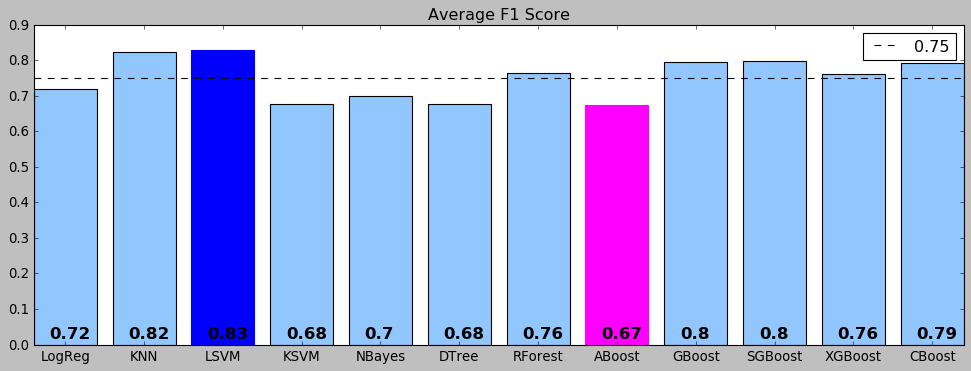

In [101]:
# Plotting F1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tfidf, category='average', title= "Average F1 Score")

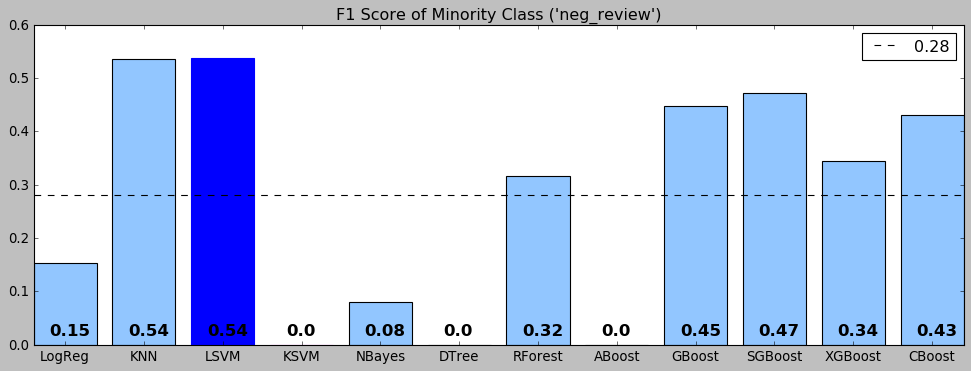

In [102]:
# Plotting F1 score of minority class ('bad') with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tfidf, category='neg_review', title= "F1 Score of Minority Class ('neg_review')")

- The best scores with Tfidf Vectorizer, both in average and minority class F1 score was made by LSVM: 0.83 and 0.54 respectively.
- AdaBoost is the weakest algorithm with Tfidf-vectorizing.
- KSVM, Decision Tree and AdaBoost share the lowest average score of 0.68 and minority score of 0.
- I will save the results for further comparison.

In [103]:
df_tfidf2.to_csv('3b_TfidfVectorized.csv', sep=',', encoding='utf-8')